In [126]:
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Prep

In [127]:
df = pd.read_csv('saas.csv')
df.sort_index(ascending=True, inplace=True)

In [128]:
def prep_saas_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    df['month_invoiced'] = pd.to_datetime(df.Month_Invoiced)
    df = df.set_index('month_invoiced').sort_index()
    return df

In [129]:
df = prep_saas_data(df)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 36.2+ MB


In [131]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Id,790458.0,1.012913e+06,7591.991578,1000000.0,1006405.00,1012797.0,1019154.00,1029399.0
Invoice_Id,790458.0,5.395228e+06,228185.713880,5000000.0,5197614.25,5395228.5,5592842.75,5790457.0
Subscription_Type,790458.0,5.992349e-01,0.950380,0.0,0.00,0.0,1.00,4.0
Amount,790458.0,2.996174e+00,4.751901,0.0,0.00,0.0,5.00,20.0


In [132]:
df_resampled = df.resample('M')[['Subscription_Type', 'Amount']].sum()

In [133]:
train_size = int(round(df_resampled.shape[0]*0.5))
train_size

24

In [134]:
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

14

In [135]:
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

10

In [136]:
len(df_resampled) == train_size + validate_size + test_size

True

In [137]:
validate_end_index = train_size + validate_size
validate_end_index

38

In [138]:
train = df_resampled[:train_size]

In [139]:
train.tail()

,Subscription_Type,Amount
month_invoiced,,
2015-08-31,10099.0,50495.0
2015-09-30,10197.0,50985.0
2015-10-31,10289.0,51445.0
2015-11-30,10252.0,51260.0
2015-12-31,10301.0,51505.0


In [140]:
validate = df_resampled[train_size:validate_end_index]

In [141]:
validate.tail()

,Subscription_Type,Amount
month_invoiced,,
2016-10-31,10638.0,53190.0
2016-11-30,10675.0,53375.0
2016-12-31,10664.0,53320.0
2017-01-31,10679.0,53395.0
2017-02-28,10688.0,53440.0


In [142]:
test = df_resampled[validate_end_index:]

In [143]:
test.head()

,Subscription_Type,Amount
month_invoiced,,
2017-03-31,10696.0,53480.0
2017-04-30,10670.0,53350.0
2017-05-31,10668.0,53340.0
2017-06-30,10681.0,53405.0
2017-07-31,10736.0,53680.0


In [144]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [145]:
print(df_resampled.head(1) == train.head(1))

                Subscription_Type  Amount
month_invoiced                           
2014-01-31                   True    True


In [146]:
 pd.concat([test.tail(1), df_resampled.tail(1)])

,Subscription_Type,Amount
month_invoiced,,
2017-12-31,10761.0,53805.0
2017-12-31,10761.0,53805.0


In [147]:
train.columns

Index(['Subscription_Type', 'Amount'], dtype='object')

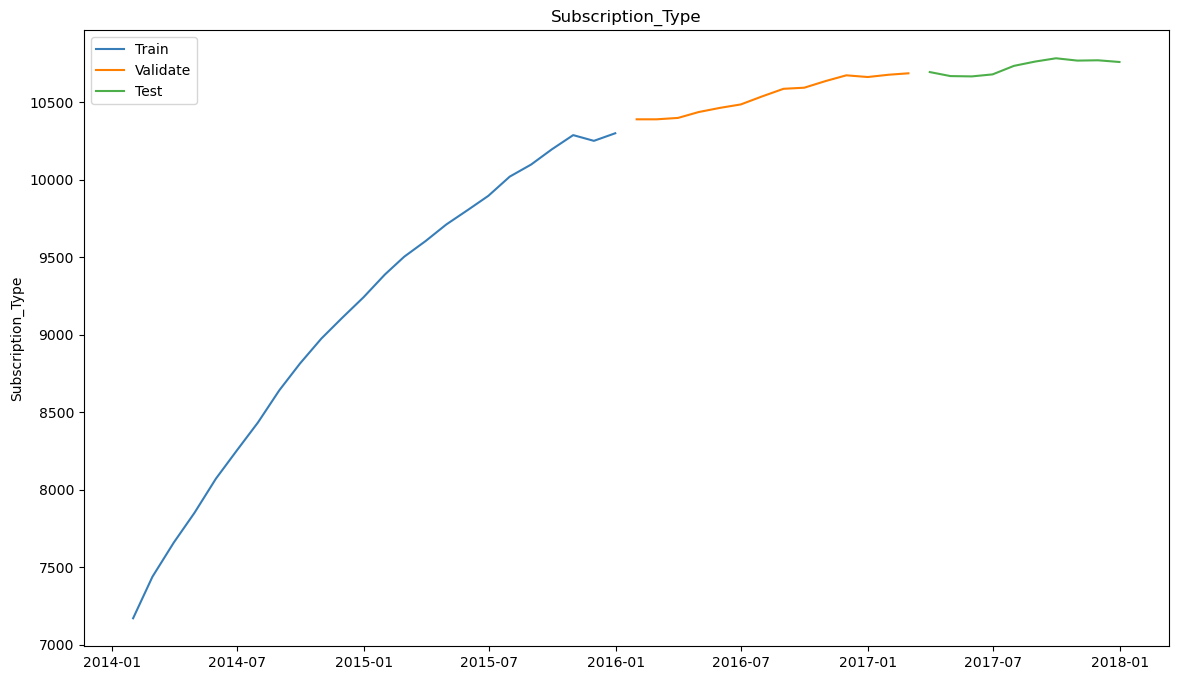

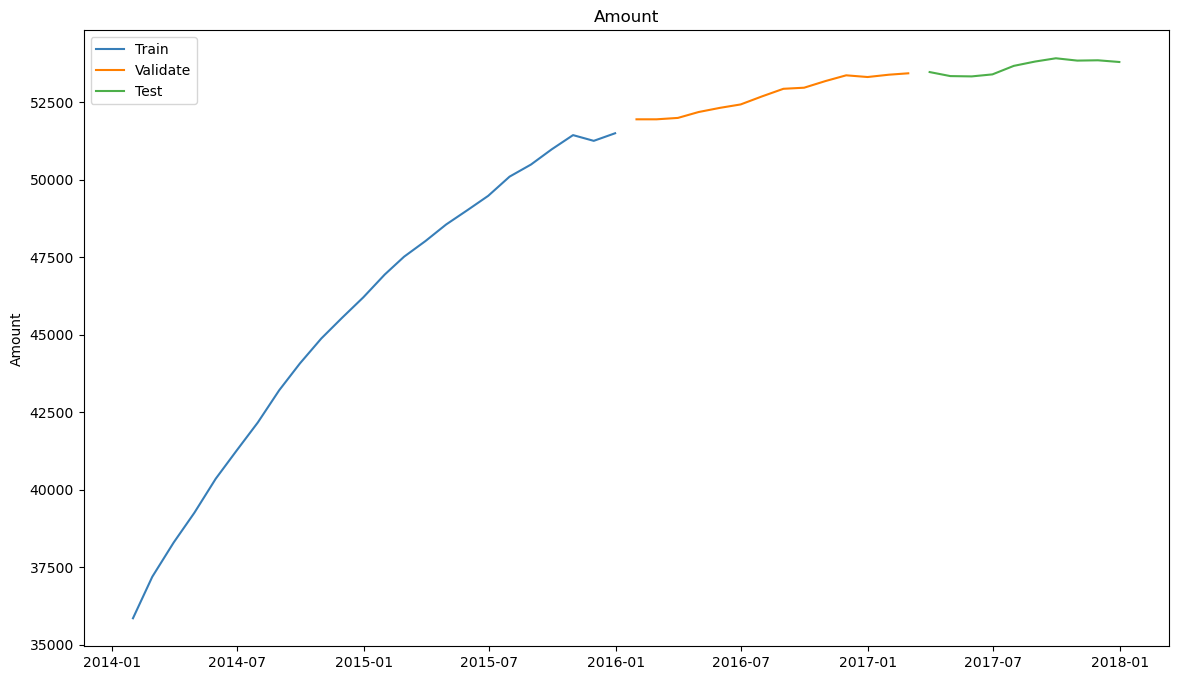

In [148]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [149]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [150]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [151]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [152]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [153]:
train['Subscription_Type'][-1:][0]

10301.0

In [154]:
last_sales = train['Subscription_Type'][-1:][0]; last_sales

10301.0

In [155]:
last_quantity = train['Amount'][-1:][0]
last_quantity

51505.0

In [156]:
yhat_df = pd.DataFrame(
    {'Subscription_Type': [last_sales],
     'Amount': [last_quantity]},
    index=validate.index)

yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,10301.0,51505.0
2016-02-29,10301.0,51505.0
2016-03-31,10301.0,51505.0
2016-04-30,10301.0,51505.0
2016-05-31,10301.0,51505.0


Subscription_Type -- RMSE: 269


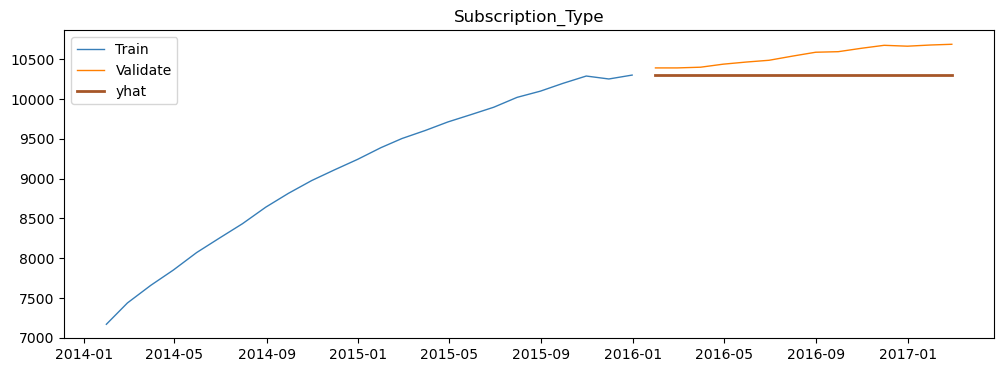

Amount -- RMSE: 1343


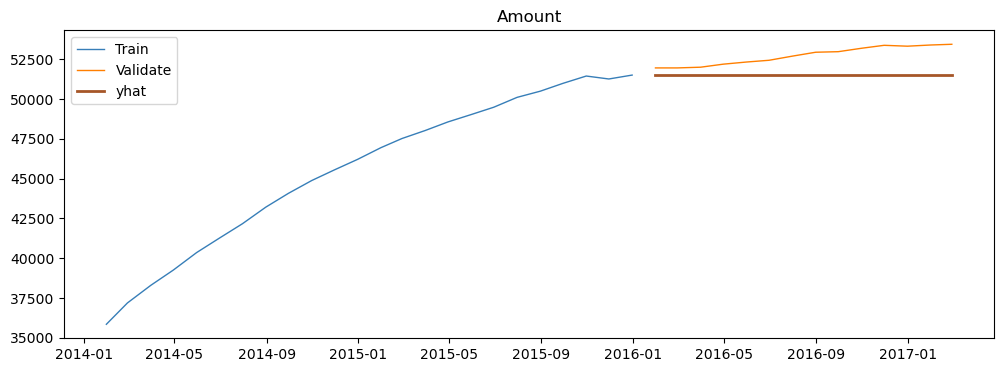

In [157]:
for col in train.columns:
    plot_and_eval(col)

In [158]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0


In [172]:
def make_baseline_predictions(sales_predictions=None, quantity_predictions=None):
    yhat_df = pd.DataFrame({'Subscription_Type': [last_sales],
                            'Amount': [last_quantity]},
                           index=validate.index)

    return yhat_df

In [174]:
period=30
train['Amount'].rolling(period).mean()

month_invoiced
2014-01-31   NaN
2014-02-28   NaN
2014-03-31   NaN
2014-04-30   NaN
2014-05-31   NaN
2014-06-30   NaN
2014-07-31   NaN
2014-08-31   NaN
2014-09-30   NaN
2014-10-31   NaN
2014-11-30   NaN
2014-12-31   NaN
2015-01-31   NaN
2015-02-28   NaN
2015-03-31   NaN
2015-04-30   NaN
2015-05-31   NaN
2015-06-30   NaN
2015-07-31   NaN
2015-08-31   NaN
2015-09-30   NaN
2015-10-31   NaN
2015-11-30   NaN
2015-12-31   NaN
Freq: M, Name: Amount, dtype: float64

In [175]:
period=30
train['Amount'].rolling(period).mean()[-1]

nan

In [176]:
rolling_sales = round(train['Subscription_Type'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['Amount'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

nan nan


In [177]:
yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,10301.0,51505.0
2016-02-29,10301.0,51505.0
2016-03-31,10301.0,51505.0
2016-04-30,10301.0,51505.0
2016-05-31,10301.0,51505.0


In [178]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,last_observed_value,Subscription_Type,269.0
3,last_observed_value,Amount,1343.0
4,30d_moving_avg,Subscription_Type,269.0
5,30d_moving_avg,Amount,1343.0


In [180]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['Subscription_Type'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['Amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [181]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,last_observed_value,Subscription_Type,269.0
3,last_observed_value,Amount,1343.0
4,30d_moving_avg,Subscription_Type,269.0
5,30d_moving_avg,Amount,1343.0
6,4_day_moving_avg,Subscription_Type,269.0
7,4_day_moving_avg,Amount,1343.0
8,12_day_moving_avg,Subscription_Type,269.0
9,12_day_moving_avg,Amount,1343.0


In [182]:
best_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [183]:
best_quantity_rmse

nan